In [36]:
! pip install yfinance

In [37]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4449    0  4449    0     0  15426      0 --:--:-- --:--:-- --:--:-- 15447
100  517k  100  517k    0     0   811k      0 --:--:-- --:--:-- --:--:-- 1729k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4533    0  4533    0     0  14510      0 --:--:-- --:--:-- --:--:-- 14528
100  392k  100  392k    0     0   570k      0 --:--:-- --:--:-- --:--:-- 6343k


In [38]:
! pip install finlab

In [39]:
! pip install fredapi
from fredapi import Fred

In [40]:
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import requests
import pandas as pd
import io
import seaborn as sns
import time
from finlab import data


(15706.0, 18628.0)

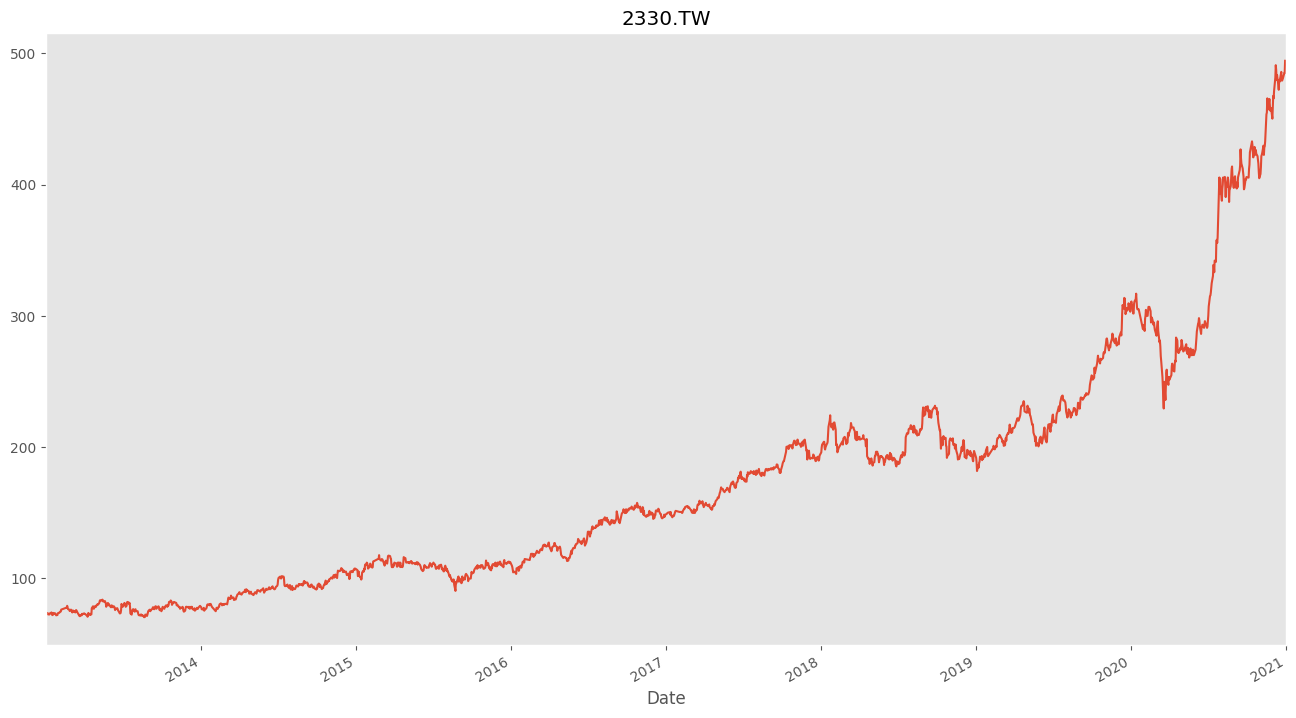

In [41]:
#畫股價圖
start_date = "2013-01-01"
end_date = "2020-12-31"

def crawl_price(stock_id):
  df = yf.Ticker(stock_id).history(start=start_date, end=end_date)
  #df = yf.Ticker(stock_id).history(period = "max")
  return df
df = crawl_price("2330.TW")
df.Close.plot()
plt.title("2330.TW")
plt.grid(False)
plt.xlim('2013-1-1','2021-1-1')

(15706.0, 18628.0)

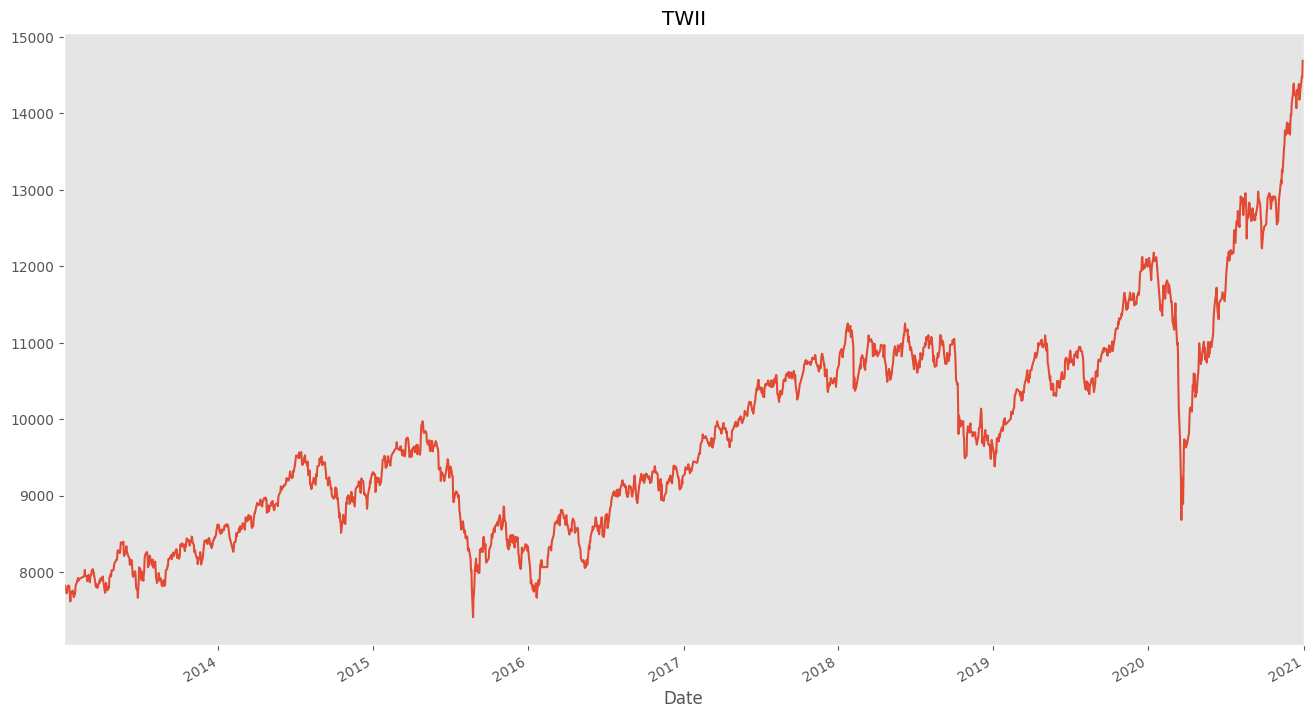

In [42]:
#畫台股圖
TWII = crawl_price("^TWII")
TWII = TWII.drop(['Dividends', 'Stock Splits'], axis=1)
TWII.Close.plot()
plt.title("TWII")
plt.grid(False)
plt.xlim('2013-1-1', '2021-1-1')

In [43]:
#同時抓多個指數

url = "https://finance.yahoo.com/world-indices/"
response = requests.get(url)

f = io.StringIO(response.text)
dfs = pd.read_html(f)
world_index = dfs[0]
world_index
# 使用 iloc 取出多列
world_index_iloc = world_index.iloc[[0,1,2,15,8,26,27],: ]
# world_index_iloc = world_index_iloc.drop(['52 Week Range', 'Day Chart','Intraday High/Low','Symbol','Volume'], axis=1)
# world_index_iloc.rename(columns={'Name':'Index_Name','Last Price':'Index'}, inplace=True)

world_index_iloc

,Symbol,Name,Last Price,Change,% Change,Volume,Intraday High/Low,52 Week Range,Day Chart
0,^GSPC,S&P 500,4697.24,8.56,+0.18%,2.205B,NaN,NaN,NaN
1,^DJI,Dow Jones Industrial Average,37466.11,25.81,+0.07%,299.489M,NaN,NaN,NaN
2,^IXIC,NASDAQ Composite,14524.07,13.77,+0.09%,4.788B,NaN,NaN,NaN
15,^N225,Nikkei 225,33377.42,89.12,+0.27%,0,NaN,NaN,NaN
8,^FTSE,FTSE 100,7681.42,-8.19,-0.11%,0,NaN,NaN,NaN
26,^KS11,KOSPI Composite Index,2567.82,-10.26,-0.40%,320144,NaN,NaN,NaN
27,^TWII,TSEC weighted index,17572.66,53.52,+0.31%,0,NaN,NaN,NaN


In [44]:
world_index_history = {}
for symbol, name in zip(world_index_iloc['Symbol'], world_index_iloc['Name']):

    print(name)

    world_index_history[name] = crawl_price(symbol)
    time.sleep(5)

S&P 500
Dow Jones Industrial Average
NASDAQ Composite
Nikkei 225
FTSE 100
TSEC weighted index


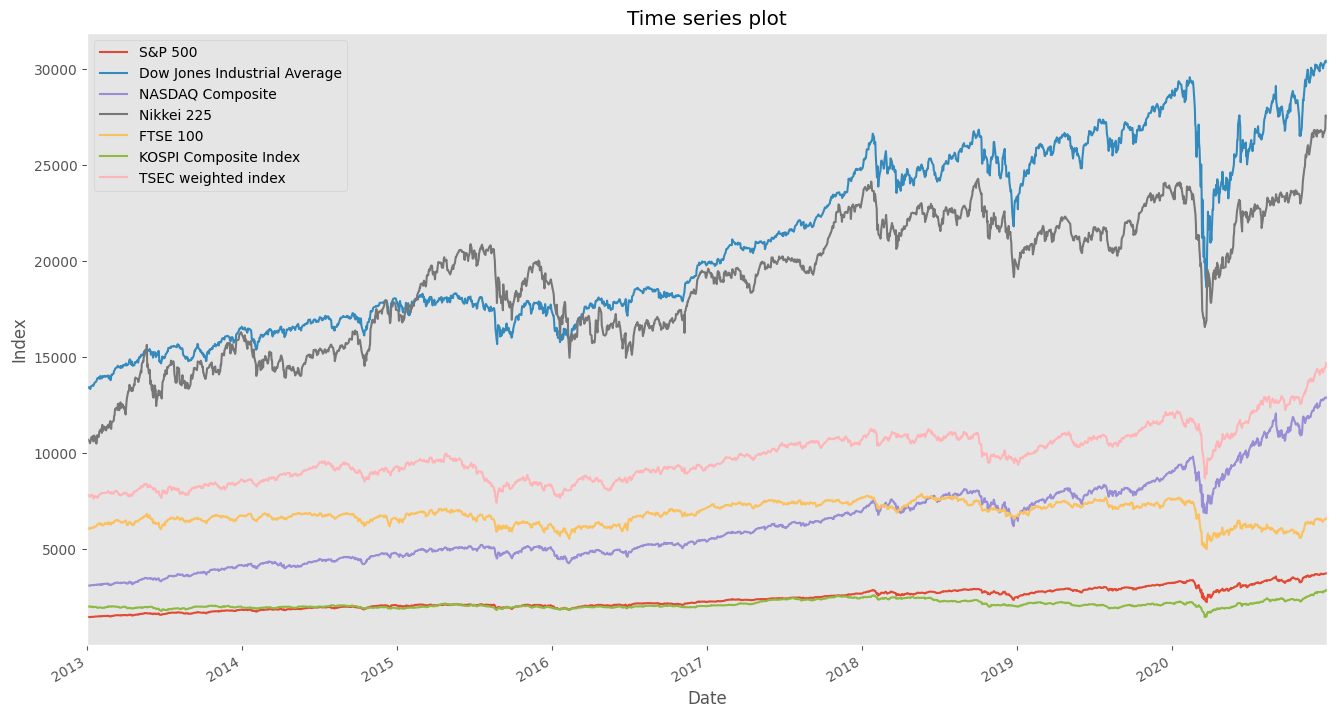

In [45]:
plt.rcParams['figure.figsize'] = (16,9)
plt.style.use('ggplot')

for name, history in world_index_history.items():
    history.Close.plot(label = name)
    plt.legend()
    plt.title('Time series plot')
    plt.xlim('2013-1-1', '2021-1-1')
    plt.grid(False)
    plt.ylabel('Index')

In [46]:
#敘述統計
summary_stat = TWII.describe()
summary_stat

,Open,High,Low,Close,Volume
count,1951.000000,1951.000000,1951.000000,1951.000000,1.951000e+03
mean,9812.455930,9852.809960,9766.709371,9810.144461,2.309570e+06
std,1381.186869,1388.177951,1376.727300,1383.003322,7.952469e+05
min,7427.331987,7677.901359,7203.042771,7410.312012,0.000000e+00
25%,8671.127944,8699.428357,8619.944467,8660.105469,1.849500e+06
50%,9608.563334,9653.933549,9562.743210,9612.963867,2.146400e+06
75%,10769.300293,10806.054688,10721.265137,10758.569824,2.534850e+06
max,14500.910156,14695.440430,14476.690430,14687.700195,8.157200e+06


In [47]:
#存入各指數的股價資料
adjclose = {}
for name, price in world_index_history.items():
    if len(price) != 0:
        adjclose[name] = price['Close']

adjclose = pd.DataFrame(adjclose)
#去除na值
adjclose = adjclose.resample('1d').last().dropna(how='all', axis=1).dropna(how='all', axis=0)
adjclose

,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index
Date,,,,,,,
2013-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,2031.099976,7779.191406
2013-01-02 00:00:00+00:00,1462.420044,13412.549805,3112.260010,NaN,6027.399902,2019.410034,7836.810547
2013-01-03 00:00:00+00:00,1459.369995,13391.360352,3100.570068,10688.110352,6047.299805,2011.939941,7805.961426
2013-01-04 00:00:00+00:00,1466.469971,13435.209961,3101.659912,NaN,6089.799805,NaN,NaN
2013-01-06 00:00:00+00:00,NaN,NaN,NaN,10599.009766,NaN,2011.250000,7755.061035
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,3703.060059,30199.869141,12804.730469,26656.609375,6502.100098,NaN,14331.419922
2020-12-27 00:00:00+00:00,NaN,NaN,NaN,26854.029297,NaN,2808.600098,14483.070312
2020-12-28 00:00:00+00:00,3735.360107,30403.970703,12899.419922,27568.150391,NaN,2820.510010,14472.049805


In [48]:
adjclose.isna()
adjclose = adjclose.fillna(method='bfill')
adjclose = adjclose.fillna(method='ffill')
adjclose

,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index
Date,,,,,,,
2013-01-01 00:00:00+00:00,1462.420044,13412.549805,3112.260010,10688.110352,6027.399902,2031.099976,7779.191406
2013-01-02 00:00:00+00:00,1462.420044,13412.549805,3112.260010,10688.110352,6027.399902,2019.410034,7836.810547
2013-01-03 00:00:00+00:00,1459.369995,13391.360352,3100.570068,10688.110352,6047.299805,2011.939941,7805.961426
2013-01-04 00:00:00+00:00,1466.469971,13435.209961,3101.659912,10599.009766,6089.799805,2011.250000,7755.061035
2013-01-06 00:00:00+00:00,1461.890015,13384.290039,3098.810059,10599.009766,6064.600098,2011.250000,7755.061035
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,3703.060059,30199.869141,12804.730469,26656.609375,6502.100098,2808.600098,14331.419922
2020-12-27 00:00:00+00:00,3735.360107,30403.970703,12899.419922,26854.029297,6602.700195,2808.600098,14483.070312
2020-12-28 00:00:00+00:00,3735.360107,30403.970703,12899.419922,27568.150391,6602.700195,2820.510010,14472.049805


In [49]:
corr = adjclose.corr()
print(corr)

                               S&P 500  Dow Jones Industrial Average  \
S&P 500                       1.000000                      0.984305   
Dow Jones Industrial Average  0.984305                      1.000000   
NASDAQ Composite              0.983559                      0.946861   
Nikkei 225                    0.918259                      0.916366   
FTSE 100                      0.313277                      0.422750   
KOSPI Composite Index         0.638738                      0.654495   
TSEC weighted index           0.951460                      0.923601   

                              NASDAQ Composite  Nikkei 225  FTSE 100  \
S&P 500                               0.983559    0.918259  0.313277   
Dow Jones Industrial Average          0.946861    0.916366  0.422750   
NASDAQ Composite                      1.000000    0.878769  0.172179   
Nikkei 225                            0.878769    1.000000  0.431936   
FTSE 100                              0.172179    0.431936  1.0

<Axes: >

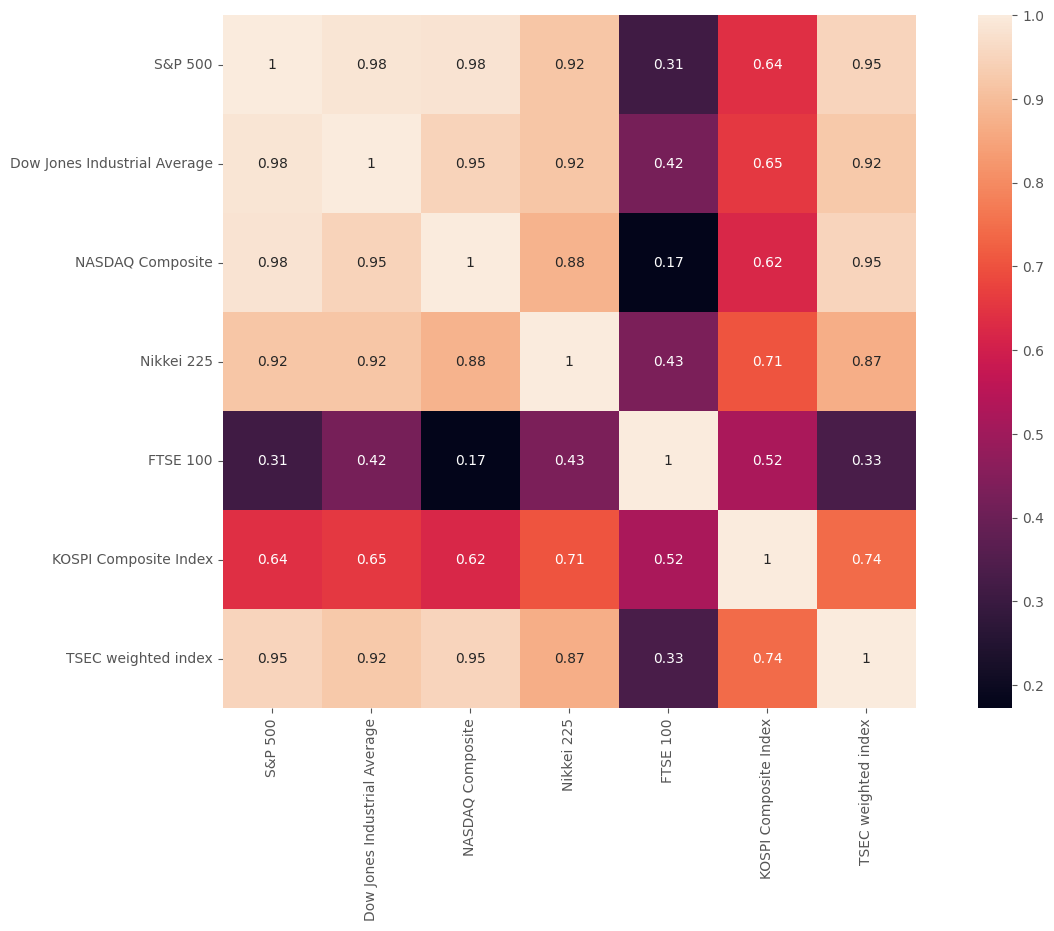

In [50]:
import seaborn as sns
sns.heatmap(corr, square=True ,vmax=1.0, linecolor='white', annot=True)

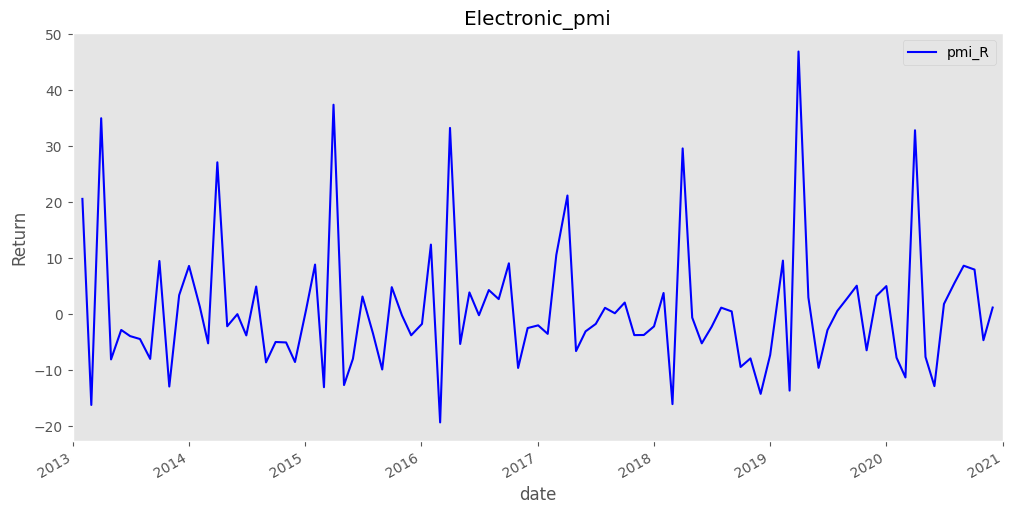

In [51]:
from finlab import data

pmi = data.get('tw_industry_pmi:製造業PMI')
pmi=pmi[pmi.index<='2020-12-31']
# 选择第五列并重新分配给 df
pmi = pmi.iloc[:, [4]]
pmi.rename(columns={'電子暨光學產業': 'Electronic_pmi'}, inplace=True)
pmi['pmi_R'] = (pmi['Electronic_pmi'].pct_change() * 100).round(2)
#繪製pmi圖表
plt.figure(figsize=(12, 6))
pmi.pmi_R.plot(color='blue')
#plt.axhline(y=50, color='r', linestyle='--', label='Balance')
plt.title("Electronic_pmi")
plt.xlim('2013-1-1', '2021-1-1')
plt.ylabel('Return')
plt.grid(False)
plt.legend()
plt.show()

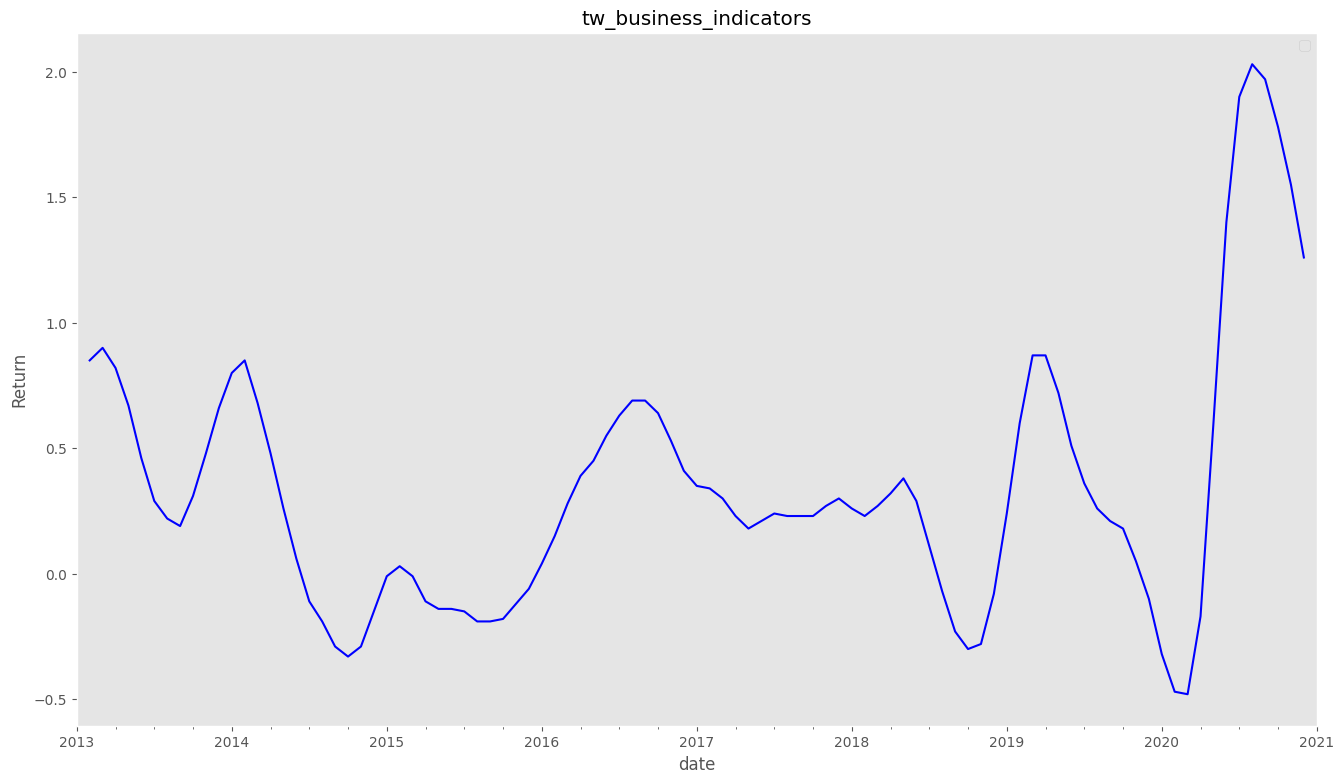

In [52]:
tw_business_indicators = data.get('tw_business_indicators:領先指標綜合指數(點)')
tw_business_indicators=tw_business_indicators[tw_business_indicators.index<='2020-12-31']
tw_business_indicators['tw_business_indicators_R'] = (tw_business_indicators['tw_business_indicators'].pct_change() * 100).round(2)

tw_business_indicators.tw_business_indicators_R.plot(color='b')
plt.title("tw_business_indicators")
plt.xlim('2013-1-1', '2021-1-1')
plt.legend([], handlelength=0)
plt.ylabel('Return')
plt.grid(False)
plt.show()

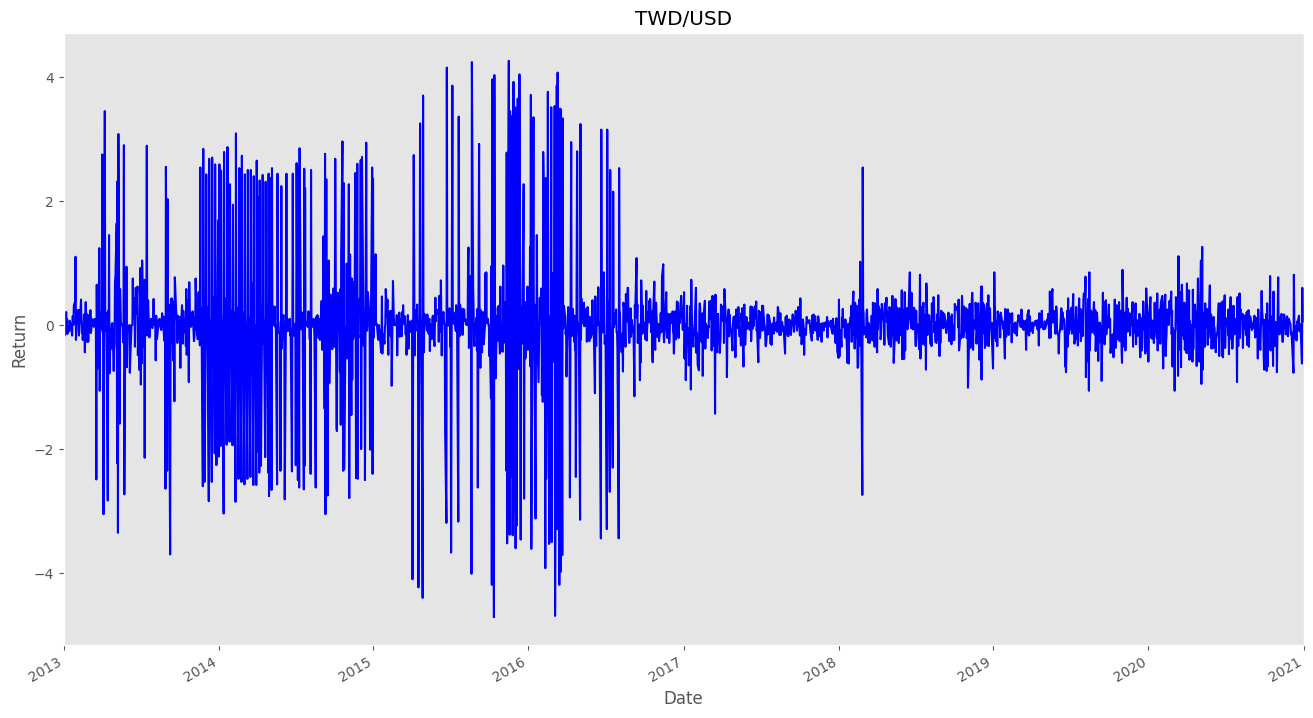

In [53]:
TWD = crawl_price("TWD=X")
min_index = TWD['Close'].idxmin()
TWD  = TWD.loc[:, 'Close']
# 新值
new_value = 31.69

# 使用 loc 設置新值
TWD_copy = TWD.copy()  # 創建副本
TWD_copy.loc[min_index] = new_value

# 将修改后的副本赋值回原始数据
TWD = TWD_copy
TWD = pd.DataFrame(TWD)
#改成報酬率
TWD['TWD_R'] = (TWD['Close'].pct_change() * 100).round(2)

# 繪製圖表
TWD.TWD_R.plot(color='b')
plt.title("TWD/USD")
plt.xlim('2013-1-1', '2021-1-1')
plt.grid(False)
plt.ylabel('Return')
plt.show()

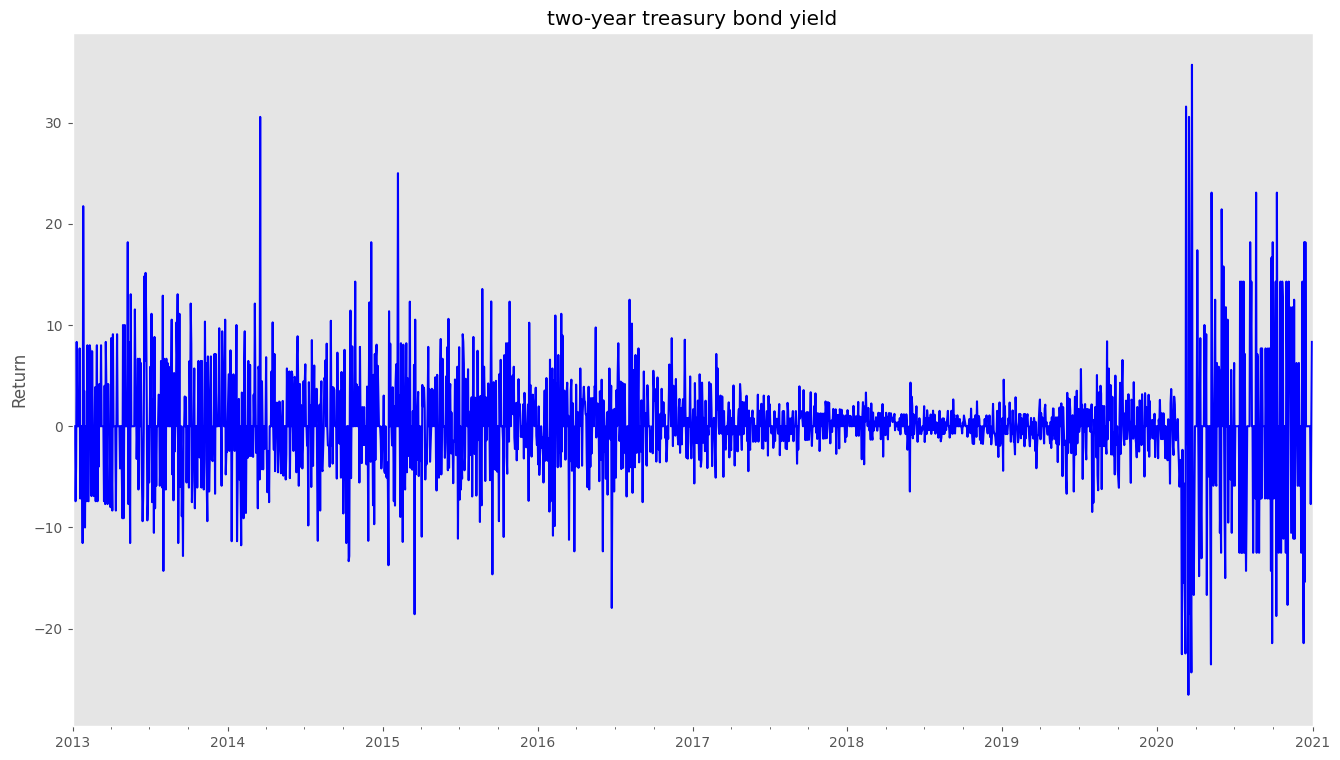

In [54]:
# 設定 API Key
api_key = 'eb2cec97407fb91cc46fd8e566135ec2'
fred = Fred(api_key=api_key)
bond = fred.get_series('DGS2', observation_start='2013-01-01', observation_end='2020-12-31')  # 美國二年期公債殖利率
bond = pd.DataFrame(bond)
bond = bond.rename(columns={0: 'yield'})
bond['bond_R'] = (bond['yield'].pct_change() * 100).round(2)
# 繪製圖表
bond.bond_R.plot(color='b')
plt.title("two-year treasury bond yield")
plt.xlim('2013-1-1', '2021-1-1')
plt.grid(False)
plt.ylabel('Return')
plt.show()

In [55]:
ppi = fred.get_series('PPIACO', observation_start='2013-01-01', observation_end='2020-12-31')  # 美國ppi
ppi = pd.DataFrame(ppi)
ppi.rename(columns={0: 'ppi'}, inplace=True)

# 計算每日報酬率
ppi['ppi_R'] = (ppi['ppi'].pct_change() * 100).round(2)

# 打印包含報酬率的 DataFrame
print(ppi[['ppi', 'ppi_R']])

              ppi  ppi_R
2013-01-01  202.5    NaN
2013-02-01  204.3   0.89
2013-03-01  204.0  -0.15
2013-04-01  203.5  -0.25
2013-05-01  204.1   0.29
...           ...    ...
2020-08-01  194.3   0.67
2020-09-01  195.5   0.62
2020-10-01  196.5   0.51
2020-11-01  198.3   0.92
2020-12-01  200.5   1.11

[96 rows x 2 columns]


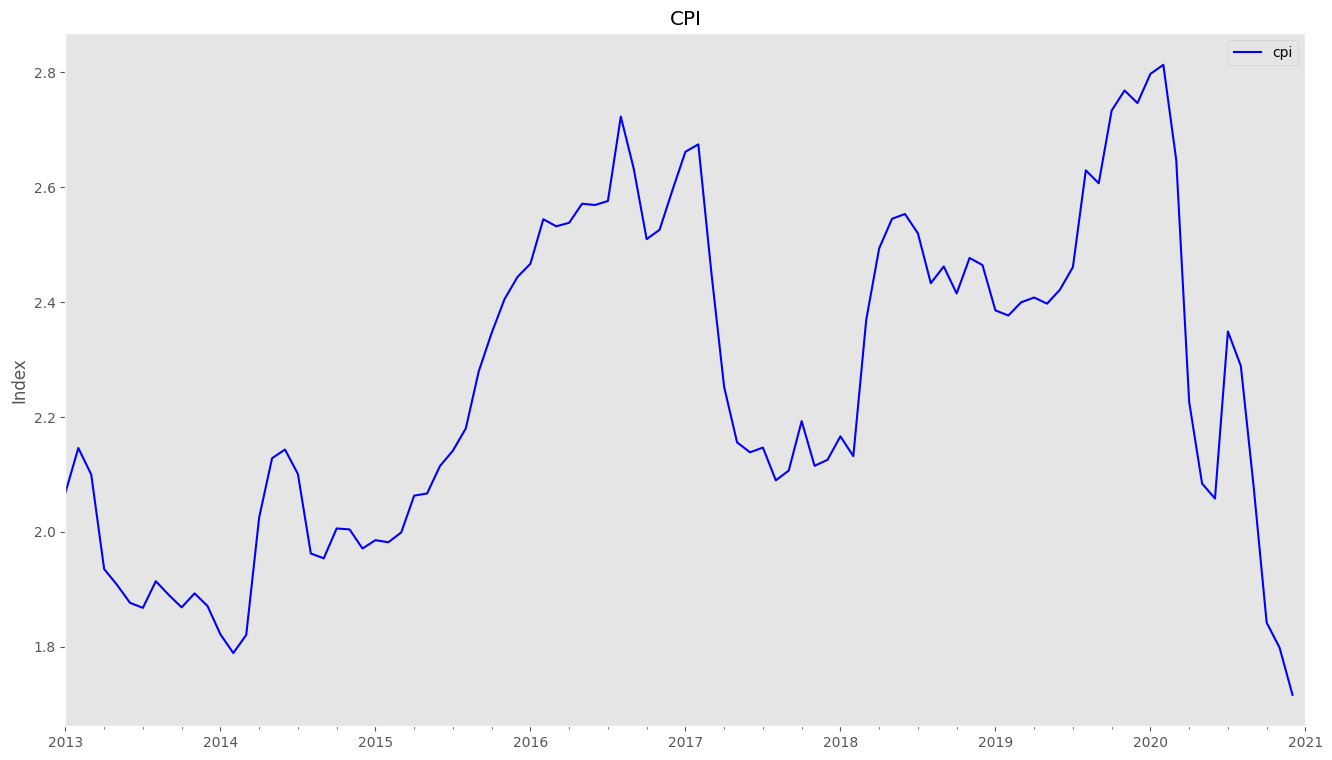

In [56]:
fred = Fred(api_key=api_key)
cpi = fred.get_series('CORESTICKM159SFRBATL', observation_start='2013-01-01', observation_end='2020-12-31')  # 美國CPI
cpi = pd.DataFrame(cpi)
cpi.rename(columns={0: 'cpi'}, inplace=True)
# 繪製圖表
cpi.plot(color='b')
plt.title("CPI")
plt.xlim('2013-1-1', '2021-1-1')
plt.grid(False)
plt.ylabel('Index')
plt.show()

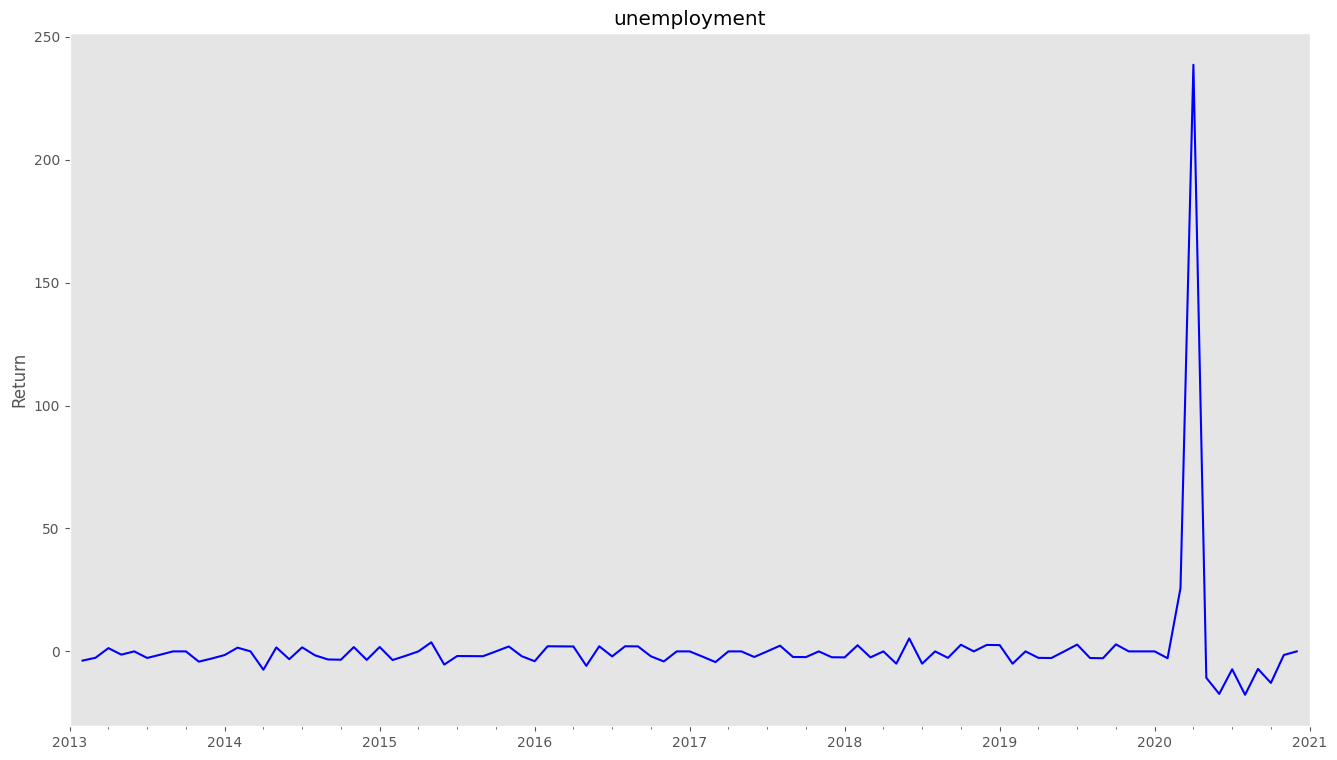

In [57]:
fred = Fred(api_key=api_key)
unemployment = fred.get_series('UNRATE', observation_start='2013-01-01', observation_end='2020-12-31')  # 美國失業率
unemployment = pd.DataFrame(unemployment)
unemployment = unemployment.rename(columns={0: 'unemployment'})
unemployment['unemployment_R'] = (unemployment['unemployment'].pct_change() * 100).round(2)


# 繪製圖表
unemployment.unemployment_R.plot(color='b')
plt.title("unemployment")
plt.xlim('2013-1-1', '2021-1-1')
plt.grid(False)
plt.ylabel('Return')
plt.show()

In [58]:
from scipy.interpolate import interp1d
# 將月數據轉換為每日數據
daily_dates = pd.date_range(start='2013-01-01', end='2020-12-31', freq='D')
daily_tw_business = tw_business_indicators.reindex(daily_dates, method='ffill')
#daily_tw_business = daily_tw_business.fillna(method='bfill')
daily_cpi = cpi.reindex(daily_dates, method='ffill')
#daily_cpi = daily_cpi.fillna(method='bfill')
daily_bond = bond.reindex(daily_dates, method='ffill')
#daily_bond = daily_bond.fillna(method='bfill')
daily_unemployment = unemployment.reindex(daily_dates, method='ffill')
#daily_unemployment = daily_unemployment.fillna(method='bfill')
daily_ppi = ppi.reindex(daily_dates, method='ffill')
daily_pmi = pmi.reindex(daily_dates, method='ffill')
daily_dates = daily_dates.tz_localize(None)
daily_adjclose = adjclose.reindex(daily_dates)
daily_TWD = TWD.reindex(daily_dates)
daily_TWD = TWD.rename(columns={'Close': 'TWD/USD'})


# 創建新的DataFrame
print(daily_pmi)
print(daily_tw_business)
print(daily_adjclose)
print(daily_TWD)
print(daily_ppi)
print(daily_cpi)
print(daily_bond)
print(daily_unemployment)

symbol      Electronic_pmi  pmi_R
2013-01-01            48.1    NaN
2013-01-02            48.1    NaN
2013-01-03            48.1    NaN
2013-01-04            48.1    NaN
2013-01-05            48.1    NaN
...                    ...    ...
2020-12-27            60.2   1.18
2020-12-28            60.2   1.18
2020-12-29            60.2   1.18
2020-12-30            60.2   1.18
2020-12-31            60.2   1.18

[2922 rows x 2 columns]
symbol      tw_business_indicators  tw_business_indicators_R
2013-01-01                     NaN                       NaN
2013-01-02                     NaN                       NaN
2013-01-03                     NaN                       NaN
2013-01-04                     NaN                       NaN
2013-01-05                     NaN                       NaN
...                            ...                       ...
2020-12-27                  125.14                      1.55
2020-12-28                  125.14                      1.55
2020-12-29        

In [59]:
#將日期設為index
daily_pmi.index = daily_pmi.index.date
daily_TWD.index = daily_TWD.index.date
daily_adjclose.index = daily_adjclose.index.date
daily_tw_business.index = daily_tw_business.index.date
daily_ppi.index = daily_ppi.index.date
daily_cpi.index = daily_cpi.index.date
daily_bond.index = daily_bond.index.date
daily_unemployment.index = daily_unemployment.index.date
TWII.index = TWII.index.date


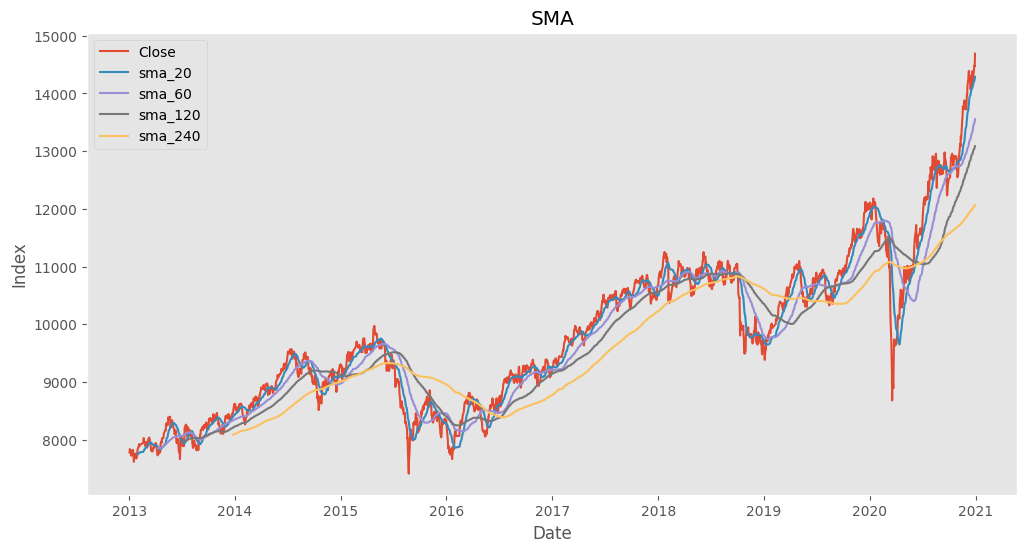

In [60]:
sma_20 = talib.SMA(TWII["Close"], 20)      # 20日移動平均線
sma_60 = talib.SMA(TWII["Close"], 60)      # 60日移動平均線
sma_120 = talib.SMA(TWII["Close"], 120)      # 120日移動平均線
sma_240 = talib.SMA(TWII["Close"], 240)  # 240日移動平均線

plt.figure(figsize=(12,6))
plt.plot(TWII["Close"],label="Close")
plt.plot(sma_20,label="sma_20")
plt.plot(sma_60,label="sma_60")
plt.plot(sma_120,label="sma_120")
plt.plot(sma_240,label="sma_240")
plt.ylabel('Index')
plt.xlabel('Date')
plt.grid(False)
plt.title('SMA')
plt.legend()
plt.show()

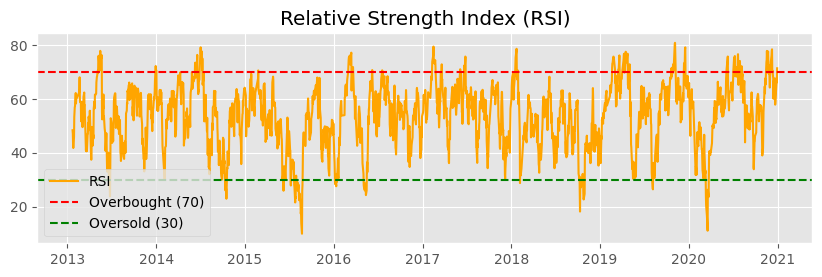

In [61]:
TWII['RSI'] = talib.RSI(TWII['Close'], timeperiod=14)
plt.figure(figsize=(10,6))
plt.subplot(2, 1, 2)
plt.plot( TWII['RSI'], label='RSI', color='orange')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.title('Relative Strength Index (RSI)')
plt.legend()

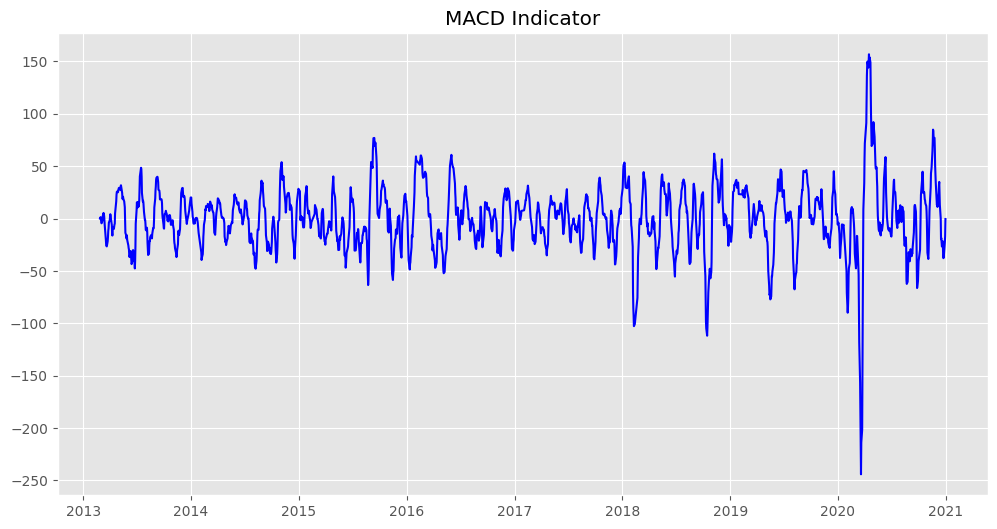

In [62]:
TWII['MACD'], TWII['Signal'], TWII['Hist'] = talib.MACD(TWII['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
# 繪製 MACD 和 Signal
plt.figure(figsize=(12, 6))
plt.plot( TWII['Hist'],color='b')
#plt.plot( TWII['Signal'], label='Signal')
plt.title('MACD Indicator')
plt.show()

In [63]:
# Calculate daily returns
index_returns = adjclose.pct_change()*100
index_returns = index_returns.dropna(how = 'all', axis=0)
index_returns['TSEC weighted index'] = index_returns['TSEC weighted index'].shift(-1)
# Print the result
index_returns

,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index
Date,,,,,,,
2013-01-02 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.575547,-0.393644
2013-01-03 00:00:00+00:00,-0.208562,-0.157982,-0.375609,0.000000,0.330157,-0.369915,-0.652071
2013-01-04 00:00:00+00:00,0.486510,0.327447,0.035150,-0.833642,0.702793,-0.034292,0.000000
2013-01-06 00:00:00+00:00,-0.312312,-0.379004,-0.091882,0.000000,-0.413802,0.000000,-0.431069
2013-01-07 00:00:00+00:00,0.000000,0.000000,0.000000,-0.858101,0.000000,-0.661780,0.219901
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,0.353659,0.232458,0.263251,-0.044023,0.096990,0.061991,1.058167
2020-12-27 00:00:00+00:00,0.872253,0.675836,0.739488,0.740604,1.547194,0.000000,-0.076092
2020-12-28 00:00:00+00:00,0.000000,0.000000,0.000000,2.659270,0.000000,0.424052,1.490116


In [64]:
index_returns.index = pd.to_datetime(index_returns.index)
train = index_returns[index_returns.index < '2019-01-01']
test = index_returns[index_returns.index > '2018-12-31']
final_train_data = train
final_train_data['TSEC weighted index'] = final_train_data['TSEC weighted index'].shift(0)
final_test_data = test
final_test_data

<ipython-input-64-948c34aa12b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data['TSEC weighted index'] = final_train_data['TSEC weighted index'].shift(0)


,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index
Date,,,,,,,
2019-01-01 00:00:00+00:00,0.126850,0.080503,0.462078,0.000000,0.090666,0.000000,-0.646000
2019-01-02 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.810948,-1.157873
2019-01-03 00:00:00+00:00,-2.475673,-2.827091,-3.036930,0.000000,-0.616257,0.830117,2.214653
2019-01-04 00:00:00+00:00,3.433571,3.292481,4.260228,2.438456,2.162053,1.335654,0.000000
2019-01-06 00:00:00+00:00,0.701043,0.419019,1.255559,0.000000,-0.387574,0.000000,-0.278408
...,...,...,...,...,...,...,...
2020-12-24 00:00:00+00:00,0.353659,0.232458,0.263251,-0.044023,0.096990,0.061991,1.058167
2020-12-27 00:00:00+00:00,0.872253,0.675836,0.739488,0.740604,1.547194,0.000000,-0.076092
2020-12-28 00:00:00+00:00,0.000000,0.000000,0.000000,2.659270,0.000000,0.424052,1.490116


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:32:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


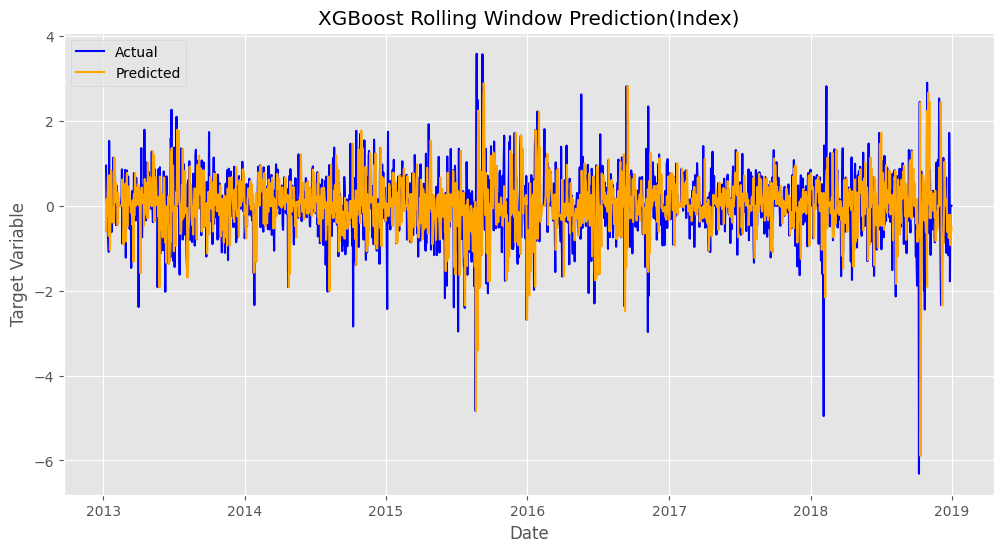

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# 指定滾動窗口的大小
window_size = 5  # 根據您的需求調整窗口大小
# 初始化XGBoost模型
model = XGBRegressor(learning_rate=0.1,
    n_estimators=400,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
# 開始滾動窗口訓練和預測
predictions = []
train = []
for i in range(len(final_train_data) - window_size):
    # 構建當前窗口的特徵和目標變量
    window_data = final_train_data.iloc[i:i+window_size]
    X_train = window_data.drop('TSEC weighted index', axis=1)
    y_train = window_data['TSEC weighted index']

    # 訓練XGBoost模型
    model.fit(X_train, y_train)

    # 預測下一個時間點的值
    X_next = final_train_data.iloc[i+window_size:i+window_size+1].drop('TSEC weighted index', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    predictions.append(y_pred[-1])
    train.append(y_train[-1])

# 保存模型到二進制文件
model.save_model('your_model.bin')

# 繪製預測值和實際值的圖形
plt.figure(figsize=(12, 6))
plt.plot(final_train_data.index[window_size:], final_train_data['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(final_train_data.index[window_size:], predictions, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction(Index)')
plt.legend()
plt.show()

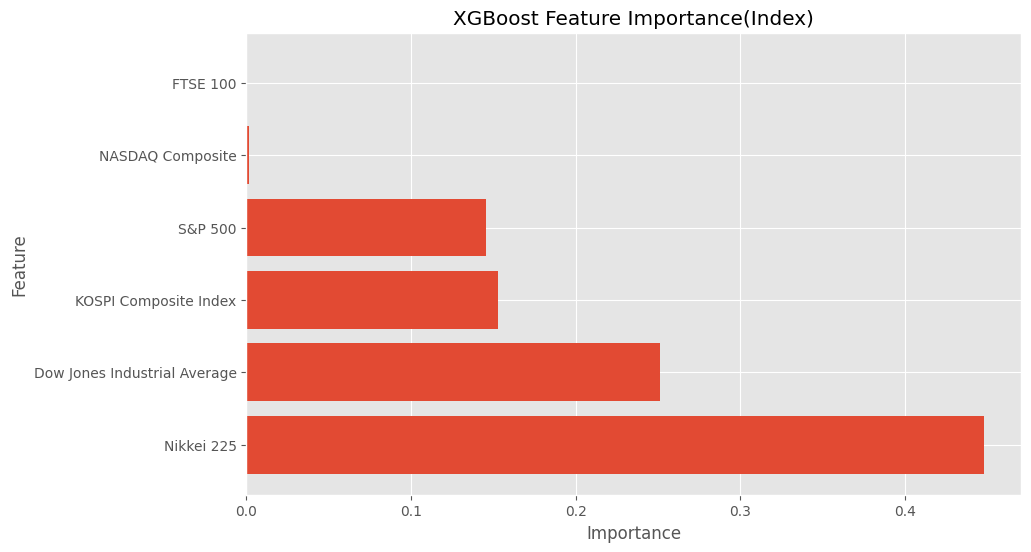

In [67]:
# 使用你的數據進行模型訓練...

# 獲取特徵重要性
feature_importance = model.feature_importances_

# 獲取特徵名稱
feature_names = X_train.columns  # X 是你的特徵數據

# 創建一個 DataFrame 以便於顯示
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 排序並繪製條形圖
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance(Index)')
plt.show()


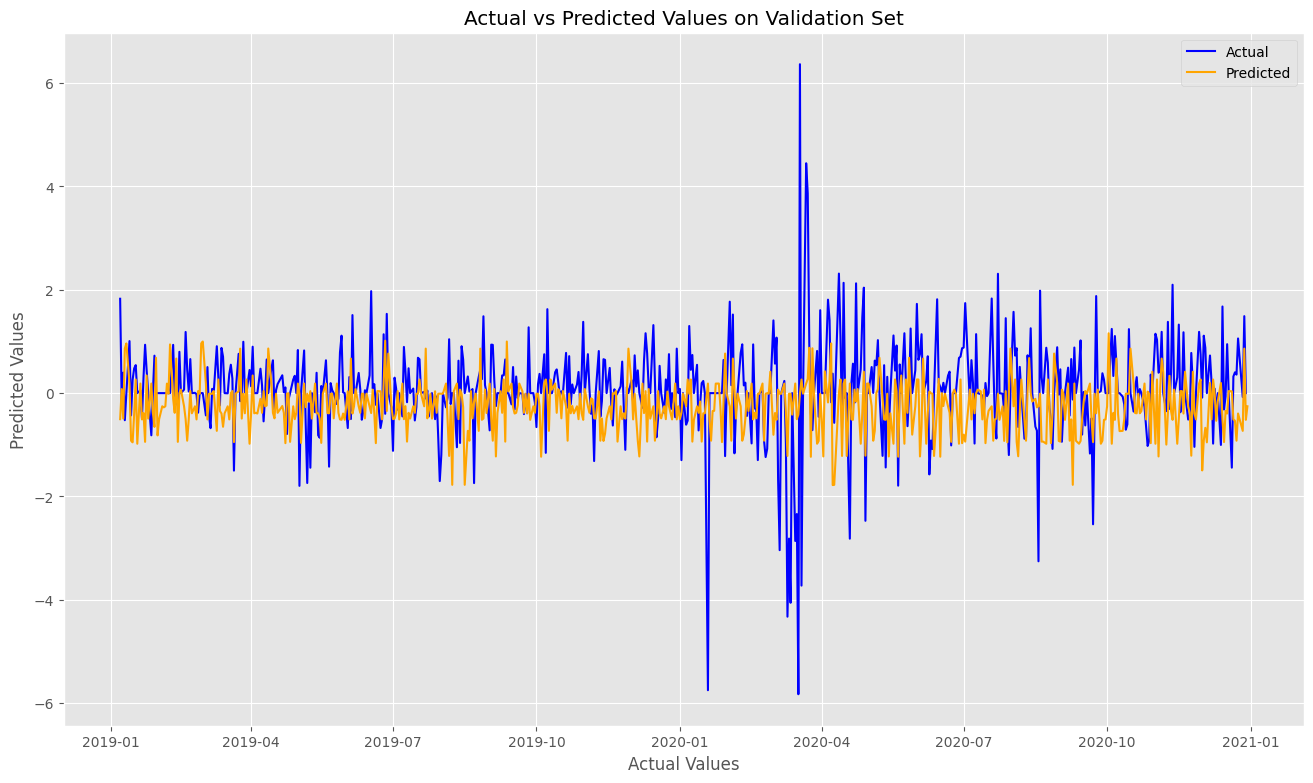

In [68]:
real_predictions = []
real = []

model.load_model('your_model.bin')
for i in range(len(final_test_data) - window_size):
    # 構建當前窗口的特徵和目標變量
    test_data = final_test_data.iloc[i:i+window_size]
    X_test = test_data.drop('TSEC weighted index', axis=1)
    y_test = test_data['TSEC weighted index']


    # 預測下一個時間點的值
    X_next = final_test_data.iloc[i+window_size:i+window_size+1].drop('TSEC weighted index', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    real_predictions.append(y_pred[-1])
    real.append(y_test[-1])


plt.plot(final_test_data.index[window_size:], final_test_data['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(final_test_data.index[window_size:], real_predictions, label='Predicted', color = 'orange')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.show()


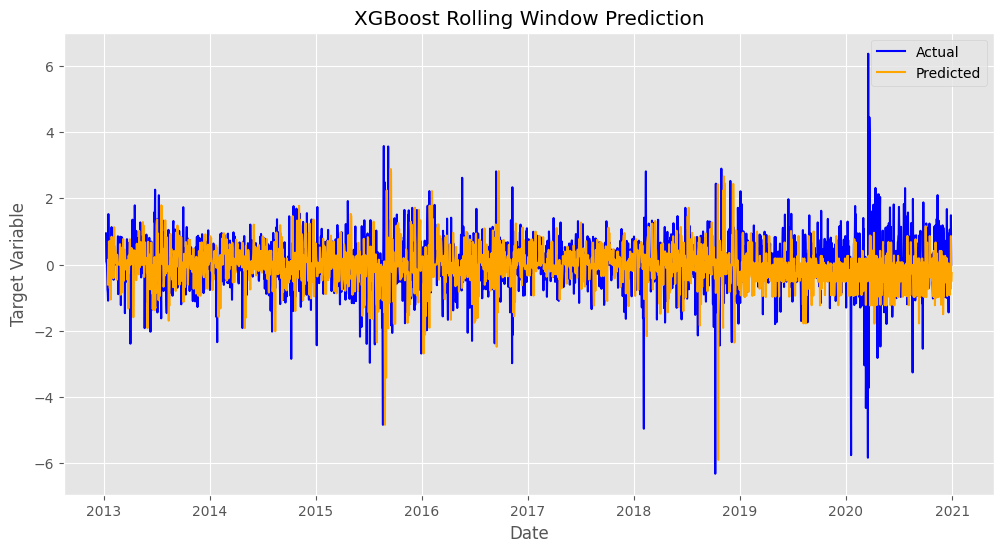

In [69]:
series_predictions = pd.Series(predictions, name='Predictions')
series_real_predictions = pd.Series(real_predictions, name='Real Predictions')
combined = pd.concat([series_predictions, series_real_predictions], axis=0,ignore_index=True)
index_returns5 = index_returns.iloc[5:]
plt.figure(figsize=(12, 6))
plt.plot(index_returns.index[window_size:], index_returns['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(index_returns5.index[window_size:], combined, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction')
plt.legend()
plt.show()

In [71]:
print(mean_squared_error(train,
                   predictions))
print(mean_squared_error(real,
                   real_predictions))

0.6527701842220657
1.2049997431989683


In [72]:
def turndate(df):
    df.index = pd.to_datetime(df.index)

    # 新增年、月、日的欄位
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day

    # 將索引轉換為年月日的字串形式並重新設置為新的索引
    df.index = df.index.strftime('%Y-%m-%d')
    return df
turndate(index_returns)
index_returns =  index_returns.iloc[:, :-3]
turndate(daily_TWD)
daily_TWD =  daily_TWD.iloc[:, :-3]
turndate(daily_pmi)
daily_pmi =  daily_pmi.iloc[:, :-3]
turndate(daily_tw_business)
daily_tw_business =  daily_tw_business.iloc[:, :-3]
turndate(daily_unemployment)
daily_unemployment =  daily_unemployment.iloc[:, :-3]
turndate(daily_bond)
daily_bond =  daily_bond.iloc[:, :-3]
turndate(daily_ppi)
daily_ppi =  daily_ppi.iloc[:, :-3]
turndate(daily_cpi)
daily_cpi =  daily_cpi.iloc[:, :-3]
turndate(TWII)
TWII =  TWII.iloc[:, :-3]


In [73]:
all_Return = pd.concat([index_returns,daily_TWD['TWD_R'],daily_pmi['pmi_R'],daily_tw_business['tw_business_indicators_R'],daily_unemployment['unemployment_R'],daily_bond['bond_R'],daily_ppi['ppi_R'],daily_cpi,TWII['Hist'],TWII['RSI']], axis = 1)
#all = pd.concat([TWII_returns['Close'],daily_TWD,daily_pmi,daily_tw_business,unemployment,bond_twomonth,ppi['Daily_Return']], axis = 1)
all_Return =all_Return.dropna()
all_Return

,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index,TWD_R,pmi_R,tw_business_indicators_R,unemployment_R,bond_R,ppi_R,cpi,Hist,RSI
2013-03-01,0.232386,0.250240,0.302199,0.395560,0.279844,0.000000,0.000000,0.14,-16.21,0.85,-2.6,0.00,-0.15,2.099902,1.409975,58.881355
2013-03-04,0.000000,0.000000,0.000000,0.267417,0.000000,0.171868,0.221739,-0.10,-16.21,0.85,-2.6,-4.00,-0.15,2.099902,-4.456686,49.579369
2013-03-05,0.956602,0.891498,1.323050,2.129673,1.361572,0.204799,0.128423,0.24,-16.21,0.85,-2.6,4.17,-0.15,2.099902,-4.144182,54.751789
2013-03-06,0.108451,0.297961,-0.054581,0.300115,-0.068406,-0.808613,0.686264,-0.13,-16.21,0.85,-2.6,0.00,-0.15,2.099902,-3.014827,56.058067
2013-03-07,0.181649,0.232579,0.301640,2.636513,0.180473,0.080323,0.294195,-0.10,-16.21,0.85,-2.6,0.00,-0.15,2.099902,-1.896785,56.836986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.207309,-0.665000,0.513245,0.334382,1.239032,0.956225,0.402096,-0.10,1.18,1.55,0.0,0.00,1.11,1.716599,-33.017099,57.942769
2020-12-23,0.074581,0.380871,-0.287397,0.541232,0.000000,1.704460,0.358114,-0.03,1.18,1.55,0.0,0.00,1.11,1.716599,-37.778923,59.335040
2020-12-24,0.353659,0.232458,0.263251,-0.044023,0.096990,0.061991,1.058167,0.01,1.18,1.55,0.0,0.00,1.11,1.716599,-37.330465,61.074352
2020-12-28,0.000000,0.000000,0.000000,2.659270,0.000000,0.424052,1.490116,-0.62,1.18,1.55,0.0,0.00,1.11,1.716599,-22.393810,66.807527


In [74]:
all_Return.to_csv('all_features.csv', index=False)

In [75]:
train = all_Return[all_Return.index < '2019-01-01']
test = all_Return[all_Return.index > '2018-12-31']
final_train_return = train
final_test_return = test
final_train_return

,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index,TWD_R,pmi_R,tw_business_indicators_R,unemployment_R,bond_R,ppi_R,cpi,Hist,RSI
2013-03-01,0.232386,0.250240,0.302199,0.395560,0.279844,0.000000,0.000000,0.14,-16.21,0.85,-2.60,0.00,-0.15,2.099902,1.409975,58.881355
2013-03-04,0.000000,0.000000,0.000000,0.267417,0.000000,0.171868,0.221739,-0.10,-16.21,0.85,-2.60,-4.00,-0.15,2.099902,-4.456686,49.579369
2013-03-05,0.956602,0.891498,1.323050,2.129673,1.361572,0.204799,0.128423,0.24,-16.21,0.85,-2.60,4.17,-0.15,2.099902,-4.144182,54.751789
2013-03-06,0.108451,0.297961,-0.054581,0.300115,-0.068406,-0.808613,0.686264,-0.13,-16.21,0.85,-2.60,0.00,-0.15,2.099902,-3.014827,56.058067
2013-03-07,0.181649,0.232579,0.301640,2.636513,0.180473,0.080323,0.294195,-0.10,-16.21,0.85,-2.60,0.00,-0.15,2.099902,-1.896785,56.836986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,-1.313862,-0.504872,0.27,-14.23,-0.28,2.63,-3.04,-0.64,2.464370,-10.697626,41.569831
2018-12-25,4.959374,4.984582,5.836341,0.894355,-1.515103,0.000000,1.715049,-0.02,-14.23,-0.28,2.63,0.00,-0.64,2.464370,-19.034937,37.047322
2018-12-26,0.000000,0.000000,0.000000,3.883460,0.000000,0.021200,0.890422,0.03,-14.23,-0.28,2.63,2.35,-0.64,2.464370,-25.914414,35.281696
2018-12-27,0.856268,1.138063,0.383415,-0.313033,0.000000,0.621172,-1.781260,0.02,-14.23,-0.28,2.63,-1.92,-0.64,2.464370,-18.016052,44.848763


In [76]:
#all_Return.index = pd.to_datetime(all_Return.index)
train = all_Return[all_Return.index < '2019-01-01']
test = all_Return[all_Return.index > '2018-12-31']
final_train_data = train
final_train_data['TSEC weighted index'] = final_train_data['TSEC weighted index'].shift(0)
final_test_data = test
final_test_data

<ipython-input-76-995c60132dee>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data['TSEC weighted index'] = final_train_data['TSEC weighted index'].shift(0)


,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,Nikkei 225,FTSE 100,KOSPI Composite Index,TSEC weighted index,TWD_R,pmi_R,tw_business_indicators_R,unemployment_R,bond_R,ppi_R,cpi,Hist,RSI
2019-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,-0.810948,-1.157873,-0.21,-7.27,-0.08,2.56,0.81,-0.95,2.385533,-8.875294,42.039637
2019-01-03,-2.475673,-2.827091,-3.036930,0.000000,-0.616257,0.830117,2.214653,0.85,-7.27,-0.08,2.56,-4.40,-0.95,2.385533,-13.520902,39.835427
2019-01-04,3.433571,3.292481,4.260228,2.438456,2.162053,1.335654,0.000000,0.34,-7.27,-0.08,2.56,4.60,-0.95,2.385533,-22.155021,36.195847
2019-01-07,0.000000,0.000000,0.000000,0.823737,0.000000,-0.580725,1.826822,-0.26,-7.27,-0.08,2.56,1.20,-0.95,2.385533,-12.511066,46.203017
2019-01-08,0.969529,1.088334,1.077601,1.103846,0.744398,1.947392,-0.180926,0.06,-7.27,-0.08,2.56,1.98,-0.95,2.385533,-6.852425,45.221536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-22,-0.207309,-0.665000,0.513245,0.334382,1.239032,0.956225,0.402096,-0.10,1.18,1.55,0.00,0.00,1.11,1.716599,-33.017099,57.942769
2020-12-23,0.074581,0.380871,-0.287397,0.541232,0.000000,1.704460,0.358114,-0.03,1.18,1.55,0.00,0.00,1.11,1.716599,-37.778923,59.335040
2020-12-24,0.353659,0.232458,0.263251,-0.044023,0.096990,0.061991,1.058167,0.01,1.18,1.55,0.00,0.00,1.11,1.716599,-37.330465,61.074352
2020-12-28,0.000000,0.000000,0.000000,2.659270,0.000000,0.424052,1.490116,-0.62,1.18,1.55,0.00,0.00,1.11,1.716599,-22.393810,66.807527


In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# 指定滾動窗口的大小
window_size = 5  # 根據您的需求調整窗口大小
# 初始化XGBoost模型
model = XGBRegressor(learning_rate=0.1,
    n_estimators=100,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
# 開始滾動窗口訓練和預測
return_predictions = []
return_train = []
for i in range(len(final_train_data) - window_size):
    # 構建當前窗口的特徵和目標變量
    window_data = final_train_data.iloc[i:i+window_size]
    X_train = window_data.drop('TSEC weighted index', axis=1)
    y_train = window_data['TSEC weighted index']

    # 訓練XGBoost模型
    model.fit(X_train, y_train)

    # 預測下一個時間點的值
    X_next = final_train_data.iloc[i+window_size:i+window_size+1].drop('TSEC weighted index', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    return_predictions.append(y_pred[-1])
    return_train.append(y_train[-1])

# 保存模型到二進制文件
model.save_model('your_model.bin')

# 繪製預測值和實際值的圖形
plt.figure(figsize=(12, 6))
plt.plot(final_train_data.index[window_size:], final_train_data['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(final_train_data[window_size:], return_predictions, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction(Index)')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt

# model = xgb.XGBRegressor(...)
# 使用你的數據進行模型訓練...

# 獲取特徵重要性
feature_importance = model.feature_importances_

# 獲取特徵名稱
feature_names = X_train.columns  # X 是你的特徵數據

# 創建一個 DataFrame 以便於顯示
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 排序並繪製條形圖
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()


In [ ]:
realR_predictions = []
realR = []

model.load_model('your_model.bin')
for i in range(len(final_test_return) - window_size):
    # 構建當前窗口的特徵和目標變量
    test_data = final_test_return.iloc[i:i+window_size]
    X_test = test_data.drop('TSEC weighted index', axis=1)
    y_test = test_data['TSEC weighted index']


    # 預測下一個時間點的值
    X_next = final_test_return.iloc[i+window_size:i+window_size+1].drop('TSEC weighted index', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    realR_predictions.append(y_pred[-1])
    realR.append(y_test[-1])


plt.plot(final_test_return.index[window_size:], final_test_return['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(final_test_return.index[window_size:], realR_predictions, label='Predicted', color = 'orange')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.show()

In [ ]:
series_return_predictions = pd.Series(return_predictions, name='Predictions')
series_realR_predictions = pd.Series(realR_predictions, name='Real Predictions')
combined = pd.concat([series_return_predictions, series_realR_predictions], axis=0,ignore_index=True)
all_Return5 = all_Return.iloc[5:]
plt.figure(figsize=(12, 6))
plt.axvline(x='2019-01-01', color='r', linestyle='--', label='Split Point')
plt.plot(all_Return5.index[window_size:], all_Return5['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(all_Return5.index[window_size:], combined, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction')
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
corr = all_Return.corr()
sns.heatmap(corr, square=True ,vmax=1.0, linecolor='white', annot=True)

In [ ]:
print(mean_squared_error(realR,
                   realR_predictions))
print(mean_squared_error(return_train,
                   return_predictions))

In [ ]:
series_predictions = pd.Series(return_predictions, name='Predictions')
series_realR_predictions = pd.Series(realR_predictions, name='Real Predictions')
combined = pd.concat([series_predictions, series_realR_predictions], axis=0,ignore_index=True)
combined

In [ ]:
# Calculate daily returns
TWII_returns = TWII.pct_change()*100
TWII_returns = TWII_returns.dropna(how = 'all', axis=0)
TWII_returns['Close'] = TWII_returns['Close'].shift(-1)
# Print the result
TWII_returns

In [ ]:
macro_return = pd.concat([TWII_returns['Close'],daily_TWD['TWD_R'],daily_pmi['pmi_R'],daily_tw_business['tw_business_indicators_R'],daily_unemployment['unemployment_R'],daily_bond['bond_R'],daily_ppi['ppi_R']], axis = 1)
macro_return =  macro_return.dropna()
macro_return

In [ ]:
train = macro_return[macro_return.index < '2019-01-01']
test = macro_return[macro_return.index > '2018-12-31']
final_train_Mreturn = train
final_test_Mreturn = test
final_train_Mreturn

In [ ]:
# 指定滾動窗口的大小
window_size = 5  # 根據您的需求調整窗口大小
# 初始化XGBoost模型
model = XGBRegressor(learning_rate=0.1,
    n_estimators=100,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
# 開始滾動窗口訓練和預測
return_Mpredictions = []
return_Mtrain = []
for i in range(len(final_train_Mreturn) - window_size):
    # 構建當前窗口的特徵和目標變量
    window_data = final_train_Mreturn.iloc[i:i+window_size]
    X_train = window_data.drop('Close', axis=1)
    y_train = window_data['Close']

    # 訓練XGBoost模型
    model.fit(X_train, y_train)

    # 預測下一個時間點的值
    X_next = final_train_Mreturn.iloc[i+window_size:i+window_size+1].drop('Close', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    return_Mpredictions.append(y_pred[-1])
    return_Mtrain.append(y_train[-1])

# 保存模型到二進制文件
model.save_model('your_modelM.bin')

# 繪製預測值和實際值的圖形
plt.figure(figsize=(12, 6))
plt.plot(final_train_return.index[window_size:], final_train_return['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(final_train_return.index[window_size:], return_predictions, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction(Index)')
plt.legend()
plt.show()

In [ ]:
tech = pd.concat([TWII_returns['Close'],TWII['RSI'],TWII['Hist']], axis = 1)
tech = tech.dropna()
tech

In [ ]:
tech['Close'] = tech['Close'].shift(1)
tech = tech.dropna()
tech.index = pd.to_datetime(tech.index)
train_tech = tech[tech.index < '2019-01-01']
test_tech = tech[tech.index > '2018-12-31']
tech_train_data = train_tech
tech_test_data = test_tech
tech_test_data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# 指定滾動窗口的大小
window_size = 5  # 根據您的需求調整窗口大小
# 初始化XGBoost模型
model = XGBRegressor(learning_rate=0.1,
    n_estimators=100,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42)
# 開始滾動窗口訓練和預測
predictions = []
train = []
for i in range(len(tech_train_data) - window_size):
    # 構建當前窗口的特徵和目標變量
    window_data = tech_train_data.iloc[i:i+window_size]
    X_train = window_data.drop('Close', axis=1)
    y_train = window_data['Close']

    # 訓練XGBoost模型
    model.fit(X_train, y_train)

    # 預測下一個時間點的值
    X_next = tech_train_data.iloc[i+window_size:i+window_size+1].drop('Close', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    predictions.append(y_pred[-1])
    train.append(y_train[-1])

# 保存模型到二進制文件
model.save_model('tech_model.bin')

# 繪製預測值和實際值的圖形
plt.figure(figsize=(12, 6))
plt.plot(tech_train_data.index[window_size:], tech_train_data['Close'][window_size:], label='Actual',color = 'b')
plt.plot(tech_train_data.index[window_size:], predictions, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction')
plt.legend()
plt.show()

In [ ]:
# 使用你的數據進行模型訓練...

# 獲取特徵重要性
feature_importance = model.feature_importances_

# 獲取特徵名稱
feature_names = X_train.columns  # X 是你的特徵數據

# 創建一個 DataFrame 以便於顯示
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# 排序並繪製條形圖
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
real_predictions = []
real = []
# 假設你的模型已經保存為 'your_model.bin'，並且有一個新的資料 'new_data.csv'
model.load_model('tech_model.bin')
for i in range(len(tech_test_data) - window_size):
    # 構建當前窗口的特徵和目標變量
    test_data = tech_test_data.iloc[i:i+window_size]
    X_test = test_data.drop('Close', axis=1)  # 請替換為實際的目標變量列名
    y_test = test_data['Close']  # 請替換為實際的目標變量列名


    # 預測下一個時間點的值
    X_next = tech_test_data.iloc[i+window_size:i+window_size+1].drop('Close', axis=1)
    y_pred = model.predict(X_next)

    # 將預測結果添加到列表中
    real_predictions.append(y_pred[-1])
    real.append(y_test[-1])


plt.plot(tech_test_data.index[window_size:], tech_test_data['Close'][window_size:], label='Actual')
plt.plot(tech_test_data.index[window_size:], real_predictions, label='Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Validation Set')
plt.legend()
plt.show()

In [ ]:
series_predictions = pd.Series(predictions, name='Predictions')
series_real_predictions = pd.Series(real_predictions, name='Real Predictions')
combined = pd.concat([series_predictions, series_real_predictions], axis=0,ignore_index=True)
index_returns5 = index_returns.iloc[5:]
plt.figure(figsize=(12, 6))
plt.plot(index_returns.index[window_size:], index_returns['TSEC weighted index'][window_size:], label='Actual',color = 'b')
plt.plot(index_returns5.index[window_size:], combined, label='Predicted',color = 'orange')
plt.xlabel('Date')
plt.ylabel('Target Variable')
plt.title('XGBoost Rolling Window Prediction')
plt.legend()
plt.show()